In [27]:
from sklearn.metrics import cohen_kappa_score
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim 
from time import time
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

In [14]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                            stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion *
                            planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        #in channels (1), 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=11, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #print(out)
        #print(type(out))
        #print(out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

class FeatureDataset(Dataset):
  
  def __init__(self, file_name):
    self.x_train = []
    self.y_train = []
    self.X_train = []
    self.Y_train = []

    count = 0
    
    name = {
        'Large': 0,
        'Small': 1,
    }
    """for root,dirs,files in os.walk(file_name):
      print(dirs)
      y = name[dirs]
      for name in files:"""
    #read csv file and load row data into variables
    for subdir in os.listdir(file_name):
      for fname in os.listdir(os.path.join(file_name, subdir)):
        full_path = os.path.join(file_name, subdir, fname)
        y = name[subdir]
        #filename = os.path.join(root,name)
        file_out = pd.read_csv(full_path, header = None) #if don't say header is none, first row will be used as header
        file_out = file_out.iloc[:,1:]
        x = file_out.iloc[0:len(file_out), 0:len(file_out)].values
        x = x[1:].astype(np.float32) # ommitting the column headers (cell names)
        #print(x[0])
        self.x_train.append(x)
        #print("x_train:", x_train)
        # y = file_out.iloc[0:32, 0:32].values
        self.y_train.append(y)
        #Converting to tensors
        X = torch.tensor(x, dtype=torch.float32) #converting to tensors (used to be self.X_train)
        self.X_train.append(X)
        #print("X_train size: ",X_train.shape)
        Y = torch.tensor(y)
        #print("Y_train size: ",Y_train.shape)
        self.Y_train.append(Y)
        count += 1
        #print(count)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.X_train[idx], self.Y_train[idx]

In [15]:
correct_count, all_count = 0, 0

correct = 0.00
total = 0.00

In [16]:
train_set = FeatureDataset("/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_2/RDT D1/Reward Size_Choice Time (s)/train")
test_set = FeatureDataset("/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_2/RDT D1/Reward Size_Choice Time (s)/test")
val_set = FeatureDataset("/media/rory/Padlock_DT/BLA_Analysis/Decoding/Pearson_Input_Datasets/Neural_Net_2/RDT D1/Reward Size_Choice Time (s)/val")
cats = ["Large", "Small"]
test_set.X_train

mini_batch_size = 1
trainloader = torch.utils.data.DataLoader(train_set, batch_size=mini_batch_size)
testloader = torch.utils.data.DataLoader(test_set, batch_size=mini_batch_size)
valloader = torch.utils.data.DataLoader(val_set, batch_size=mini_batch_size)
cats = ["Large", "Small"]

train_losses = []
valid_losses = []
val_kappa = []
test_accuracies = []
valid_accuracies = []
kappa_epoch = []
time0 = time()

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda available")
else:
    device = torch.device('cpu')
    print("cpu")

cuda available


Epoch: 0 | Training Loss: 0.068058 | Val. Loss: 0.480660 
Validation loss decreased (inf --> 0.480660).  Saving model ...
Epoch: 1 | Training Loss: 0.744693 | Val. Loss: 5.265843 
Epoch: 2 | Training Loss: 0.459028 | Val. Loss: 3.312528 
Epoch: 3 | Training Loss: 0.340540 | Val. Loss: 2.449652 
Epoch: 4 | Training Loss: 0.322891 | Val. Loss: 2.313371 
Epoch: 5 | Training Loss: 0.353937 | Val. Loss: 2.530780 
Epoch: 6 | Training Loss: 0.359246 | Val. Loss: 2.571189 
Epoch: 7 | Training Loss: 0.352046 | Val. Loss: 2.520885 
Epoch: 8 | Training Loss: 0.350703 | Val. Loss: 2.510727 
Epoch: 9 | Training Loss: 0.326249 | Val. Loss: 2.337885 
Epoch: 10 | Training Loss: 0.344779 | Val. Loss: 2.466435 
Epoch: 11 | Training Loss: 0.345041 | Val. Loss: 2.470003 
Epoch: 12 | Training Loss: 0.337642 | Val. Loss: 2.417798 
Epoch: 13 | Training Loss: 0.320374 | Val. Loss: 2.295146 
Epoch: 14 | Training Loss: 0.314278 | Val. Loss: 2.250443 
Epoch: 15 | Training Loss: 0.302065 | Val. Loss: 2.163589 
Ep

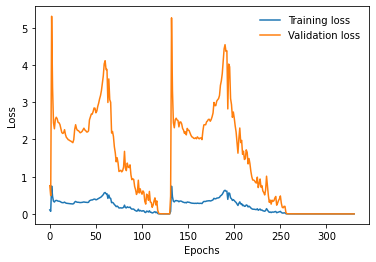

In [25]:
model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.to(device)

def train(epochs, model):
    valid_loss_min = np.Inf
    train_loss = 0.0
    valid_loss = 0.0
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            #print(images)
            #print(labels)
            images = images.unsqueeze(1)
            #print(images.shape)
            #long(images) convert types
            images = images.to(device)
            #print(images.shape)
            labels = labels.to(device)
    
            # Training pass
            optimizer.zero_grad()
    
            output = model(images).to(device)
        
            loss = criterion(output, labels)
    
            # backpropagation: calculate the gradient of the loss function w.r.t model parameters
            loss.backward()
    
            # And optimizes its weights here
            optimizer.step()
    
            running_loss += loss.item()
            
            train_loss += loss.item()*images.size(0)
            valid_loss += loss.item()*images.size(0)
            
            y_actual = labels.data.cpu().numpy()
            y_pred = output[:,-1].detach().cpu().numpy()
            #val_kappa.append(cohen_kappa_score(y_actual, y_pred.round()))  
        else:
            
            train_loss = train_loss/len(trainloader.sampler)
            valid_loss = valid_loss/len(valloader.sampler)
            #valid_kappa = np.mean(val_kappa)
            #kappa_epoch.append(np.mean(val_kappa))
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            print('Epoch: {} | Training Loss: {:.6f} | Val. Loss: {:.6f} '.format(
                e, train_loss, valid_loss))
            
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), 'trained_model_1.pt')
                valid_loss_min = valid_loss
    print("\nTraining Time (in minutes) =", (time()-time0)/60)


train(200, model)

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [42]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

actual = []
predictions = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #print(labels.item())
        actual.append(labels.item())
        images = images.to(device)
        images = images.unsqueeze(1)
        #standard for image is 4 dimensional
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        predictions.append(predicted.item())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network test images: %d %%' % (
    100 * correct / total))

torch.save(model.state_dict(), "model1")
plt.show()

Accuracy of the network test images: 65 %


130
130


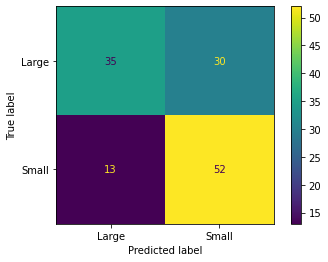

In [47]:
print(len(actual))
print(len(predictions))
cm = confusion_matrix(y_true=actual, y_pred=predictions)
#valloader.class_indices

disp = ConfusionMatrixDisplay(cm, display_labels=cats,)
#plot_confusion_matrix(cm, classes=cats, title='Confusion Matrix')
disp.plot()
plt.show()